# Requirements

- install node2vec code and add executable to your $PATH (code: https://snap.stanford.edu/node2vec)
- compile GED code (graph embedding divergence), 
  the base implementation of the framework in C (the code is included, and can also be found at      https://github.com/ftheberge/Comparing_Graph_Embeddings) 
- new package to install: 'pip install --no-dependencies graphrole'
- adjust location of data and code in next cell
  

In [1]:
## the data directory
datadir="../Datasets/"

## location of the GED code
GED="../GED/GED"

"../GED/GED"

In [2]:
## node and edge colors
cls = ["red","green","blue"]

3-element Vector{String}:
 "red"
 "green"
 "blue"

In [3]:
using PyCall

In [4]:
using LightGraphs

In [5]:
using GraphPlot

In [6]:
using Statistics

In [7]:
using Random

In [8]:
using LinearAlgebra

In [9]:
ig = pyimport("igraph")

PyObject <module 'igraph' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/igraph/__init__.py'>

In [10]:
umap = pyimport("umap")

PyObject <module 'umap' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/umap/__init__.py'>

In [11]:
partition_igraph = pyimport("partition_igraph")

PyObject <module 'partition_igraph' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/partition_igraph/__init__.py'>

In [12]:
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/numpy/__init__.py'>

# A few useful functions

In [13]:
function ig2lg(ig_g)
    lg_g = SimpleGraph(ig_g.vcount())
    for e in ig_g.es()
        add_edge!(lg_g, e.source + 1, e.target + 1)
    end
    return lg_g
end

ig2lg (generic function with 1 method)

In [14]:
function binary_operator(u, v, op=:had)
    op == :had && return u * v
    op == :l1 && return abs(u - v)
    op == :l2 && return (u - v) ^ 2
    op == :avg && return (u + v) / 2.0
    throw(ArgumentError("unknown op"))
end

binary_operator (generic function with 2 methods)

In [14]:
## Hope embedding with various similarity functions
## We only use it for undirected graphs here -- embedding as source and target are thus identical
## Dimension is doubled for directed graphs (source and target embeddings)

function Hope(g, sim, dim; beta=.01, alpha=.5)
    dim = dim*2
    A = g.get_adjacency().data
    n = g.vcount()
    ## Katz
    if sim == :katz
        M_g = I - beta * A
        M_l = beta * A
    end
    ## Adamic-Adar
    if sim == :aa
        M_g = I
        D = diagm(g.degree())
        M_l = A*D*A
    end
    ## Common neighbors
    if sim == :cn
        M_g = I
        M_l = A*A
    end
    ## rooted page rank
    if sim == :rpr
        P = mapslices(x -> x / sum(x), P, dims=1)
        M_g = I-alpha*P
        M_l = (1-alpha)*I
    end
    S = M_g \ M_l
    k = div(dim, 2)
    u, s, vt = svd(S)
    X1 = u[:, 1:k] * diagm(sqrt.(s))
    ## undirected graphs have identical source and target embeddings
    if !g.is_directed()
        return X1
    else
        X2 = (vt[:, 1:k])'' * diagm(sqrt.(s))
        return [X1 X2]
    end
end

Hope (generic function with 1 method)

# Load and prepare datasets

* g: small ABCD graph (100 nodes), mainly for visualization and quick exampes
* G: larger ABCD graph (1000 nodes), for experiments
* z: zachary graph, for visualzation

## 1. Small ABCD graph 

100 vertices, 350 edges; avg degreee: 7.0, communities: 3


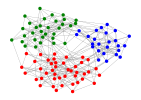

In [15]:
## read graph and communities
g = ig.Graph.Read_Ncol(datadir * "ABCD/abcd_100.dat", directed=false)
c = np.loadtxt(datadir * "ABCD/abcd_100_comms.dat", dtype="uint16", usecols=(1))
g.vs.set_attribute_values("comm", [c[parse(Int, x.attributes()["name"])] for x in g.vs])

## print a few stats
println(g.vcount()," vertices, ",
        g.ecount()," edges; ",
        "avg degreee: ", mean(g.degree()),
        ", communities: ",maximum(g.vs.get_attribute_values("comm")))

## ground truth
gt = Dict(enumerate(g.vs.get_attribute_values("comm")))
## map between name to key
n2k = Dict((v, k) for (k, v) in enumerate(g.vs.get_attribute_values("name")))

v_color = cls[g.vs.get_attribute_values("comm")]
g_lg = ig2lg(g)
Random.seed!(2)
gplot(g_lg,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

## 2. Larger ABCD graph

1000 vertices, 8327 edges; avg degreee: 16.654, communities: 12


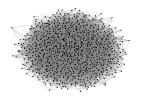

In [15]:
## read graph and communities
G = ig.Graph.Read_Ncol(datadir * "ABCD/abcd_1000.dat", directed=false)
C = np.loadtxt(datadir * "ABCD/abcd_1000_comms.dat", dtype="uint16", usecols=(1))
G.vs.set_attribute_values("comm", [C[parse(Int, x.attributes()["name"])] for x in G.vs])

## print a few stats
println(G.vcount()," vertices, ",
        G.ecount()," edges; ",
        "avg degreee: ", mean(G.degree()),
        ", communities: ",maximum(G.vs.get_attribute_values("comm")))

## ground truth
GT = Dict(enumerate(G.vs.get_attribute_values("comm")))
## map between name to key
N2K = Dict((v, k) for (k, v) in enumerate(G.vs.get_attribute_values("name")))

G_LG = ig2lg(G)
Random.seed!(2)
gplot(G_LG,
      NODESIZE=0.01, nodefillc="black",
      EDGELINEWIDTH=0.1, edgestrokec="gray") ## communities are far from obvious in 2d layout!

## 3. Zachary (karate) graph

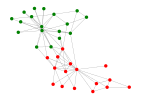

In [16]:
z = ig.Graph.Famous("zachary")
c = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1] .+ 1
z.vs.set_attribute_values("name", string.(1:z.vcount()))
z.vs.set_attribute_values("comm", [c[parse(Int, x.attributes()["name"])] for x in z.vs])

v_color = cls[z.vs.get_attribute_values("comm")]
z_lg = ig2lg(z)
Random.seed!(2)
gplot(z_lg,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Show various 2d layouts using small Zachary graph

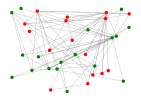

In [17]:
gplot(z_lg, layout=random_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

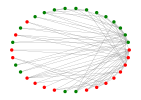

In [18]:
gplot(z_lg, layout=circular_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

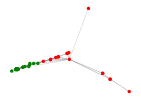

In [19]:
gplot(z_lg, layout=spectral_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Perform several embeddings -- Zachary graph
* node2vec from source code
* HOPE with different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

We use the framework to compute the "graph embedding divergence" (GED.c)

In [ ]:
L = []
DIM = [5,10,15]

## Hope
for dim in DIM:
    for sim in ['katz','aa','cn','rpr']:
        X = Hope(z,sim=sim,dim=dim) 
        saveEmbedding(X,z)
        jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
        L.append([dim,'hope',sim,jsd])

## LE
for dim in DIM:
    X = LE(z,dim=dim)
    saveEmbedding(X,z)
    jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
    L.append([dim,'le',' ',jsd])
    
## node2vec is in my path
for dim in DIM:
    for (p,q) in [(1,0.1),(0.1,1),(1,1)]:
        x = 'node2vec -i:'+datadir+'Zachary/zachary.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        jsd = JS(datadir+'Zachary/zachary.edgelist',datadir+'Zachary/zachary.ecg','_embed')
        L.append([dim,'n2v',str(p)+' '+str(q),jsd])


In [ ]:
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head()

In [ ]:
## re-run and plot top result
dim, algo, param, div = D.iloc[0]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'Zachary/zachary.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(z,sim=param,dim=dim)
    saveEmbedding(X,z) 
else:
    X = LE(z,dim=dim)
    saveEmbedding(X,z)

l = embed2layout()
z.vs['ly'] = [l[int(v['name'])] for v in z.vs]

#ig.plot(z, 'zac_high.eps', layout=z.vs['ly'], bbox=(0,0,300,200))
ig.plot(z,layout=z.vs['ly'], bbox=(0,0,300,200))



In [ ]:
D.tail()

In [ ]:
## plot bottom one
dim, algo, param, div = D.iloc[-1]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'Zachary/zachary.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(z,sim=param,dim=dim)
    saveEmbedding(X,z) 
else:
    X = LE(z,dim=dim)
    saveEmbedding(X,z)

l = embed2layout()
z.vs['ly'] = [l[int(v['name'])] for v in z.vs]
#ig.plot(z, 'zac_low.eps', layout=z.vs['ly'], bbox=(0,0,300,200))
ig.plot(z, layout=z.vs['ly'], bbox=(0,0,300,200))



# Perform several embeddings -- small ABCD  graph
* node2vec from source code
* HOPE different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

In [ ]:
L = []
DIM = [2,4,8,16,24,32]

## Hope
for dim in DIM:
    for sim in ['katz','aa','cn','rpr']:
        X = Hope(g,sim=sim,dim=dim) 
        saveEmbedding(X,g)
        jsd = JS(datadir+'ABCD/abcd_100.dat',datadir+'ABCD/abcd_100.ecg','_embed')
        L.append([dim,'hope',sim,jsd])

## LE
for dim in DIM:
    X = LE(g,dim=dim)
    saveEmbedding(X,g)
    jsd = JS(datadir+'ABCD/abcd_100.dat',datadir+'ABCD/abcd_100.ecg','_embed')
    L.append([dim,'le',' ',jsd])
    
## node2vec is in my path
for dim in DIM:
    for (p,q) in [(1,0),(1,.5),(0,1),(.5,1),(1,1)]:
        x = 'node2vec -i:'+datadir+'ABCD/abcd_100.dat -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        jsd = JS(datadir+'ABCD/abcd_100.dat',datadir+'ABCD/abcd_100.ecg','_embed')
        L.append([dim,'n2v',str(p)+' '+str(q),jsd])


In [ ]:
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head()

In [ ]:
## re-run top one and plot
dim, algo, param, div = D.iloc[0]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'ABCD/abcd_100.dat -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(g,sim=param,dim=dim)
    saveEmbedding(X,g) 
else:
    X = LE(g,dim=dim)
    saveEmbedding(X,g)

l = embed2layout()
g.vs['ly'] = [l[int(v['name'])-1] for v in g.vs]
ig.plot(g, layout=g.vs['ly'], bbox=(0,0,300,200))


In [ ]:
D.tail()

In [ ]:
## bottom one(s)
dim, algo, param, div = D.iloc[-1]
if algo=='n2v':
    s = param.split()
    p = float(s[0])
    q = float(s[1])
    x = 'node2vec -i:'+datadir+'ABCD/abcd_100.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
elif algo=='hope':
    X = Hope(g,sim=param,dim=dim)
    saveEmbedding(X,g) 
else:
    X = LE(g,dim=dim)
    saveEmbedding(X,g)

l = embed2layout()
g.vs['ly'] = [l[int(v['name'])-1] for v in g.vs]
ig.plot(g, layout=g.vs['ly'], bbox=(0,0,300,200))


# Large ABCD graph -- find a good embedding with the framework
* we only look as 16 configurations with HOPE for now (for speed)
* we'll consider more in the large classification experiment later

In [ ]:
%%time
## this is slower - we only run a few combinations (with low divergence) with HOPE
## store best one in *_embed_best
L = []
jsd_best = 1
DIM = [32,64]

## Hope
for dim in DIM:
    for sim in ['katz','rpr']:
        X = Hope(G, sim=sim, dim=dim) 
        saveEmbedding(X,G)
        jsd = JS(datadir+'ABCD/abcd_1000.dat',datadir+'ABCD/abcd_1000.ecg','_embed')
        L.append([dim,'hope',sim,jsd])
        if jsd<jsd_best:
            jsd_best=jsd
            os.system('cp _embed abcd_1000_embed_best')

## store in dataframe and show top one
os.system('rm _embed')
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head(1)


# Classification on larger ABCD graph

* we use a good embedding saved from above cell
* we use a random forest model on embedded space
* we split the data as train and test
* the goal is to recover the communities for each node


In [ ]:
## used saved "best" embedding from above
X = readEmbedding(fn="abcd_1000_embed_best")
y = G.vs['comm']
## train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)


In [ ]:
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')
# Fit on training data
model.fit(X_train, y_train)

# Class predictions on test data
y_pred = model.predict(X_test)

In [ ]:
## Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
## percent correct -- this can vary slightly as we split train/test randomly
print('\naccuracy:',sum(cm.diagonal())/sum(sum(cm)))

In [ ]:
## compare with random classifier -- assuming we know only the number of classes (12)
y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True)]
cm = confusion_matrix(y_test, y_pred)
# print(cm)
## percent correct
print('\nAccuracy:',sum(cm.diagonal())/sum(sum(cm)))

In [ ]:
## compare with random classifier -- using class proportions in training data
ctr = Counter(y_train)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
cm = confusion_matrix(y_test, y_pred)
# print(cm)
## percent correct
print('\nAccuracy:',sum(cm.diagonal())/sum(sum(cm)))

# Clustering
* we run graph clustering (Louvain, ECG)
* we compare with vector space embedding using same embedding
* we use k-means (various k) and DBSCAN
* recall there are 12 ground truth community

In [ ]:
## again we use 'good' embedding from before
X = readEmbedding(fn="abcd_1000_embed_best")

In [ ]:
L = []
K = [6,9,12,15,24] ## for k-means (real number of clusters is 12)
REP = 30

for i in range(REP):
    
    ## kmeans
    for k in K:
        cl = KMeans(n_clusters=k).fit(X)
        d = {k:v for k,v in enumerate(cl.labels_)}
        scr = CHS(X,cl.labels_)
        ami = AMI(list(GT.values()),list(d.values()))
        L.append(['km'+str(k),scr,ami])

    ## ECG
    ec = G.community_ecg().membership
    scr = G.modularity(ec)
    ami = AMI(list(GT.values()),ec)
    L.append(['ecg',scr,ami])
    
    ## Louvain -- permute as this is not done in igraph
    p = np.random.permutation(G.vcount()).tolist()
    GG = G.permute_vertices(p)
    l = GG.community_multilevel().membership
    ll = [-1]*len(l)
    for i in range(len(l)):
        ll[i] = l[p[i]]
    scr = G.modularity(ll)
    ami = AMI(list(GT.values()),ll)
    L.append(['ml',scr,ami])

In [ ]:
## results with best score for 3 algorithms
D = pd.DataFrame(L,columns=['algo','scr','ami'])

x = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ami'])[0]
print('K-Means:',x)

x = list(D[D['algo']=='ml'].sort_values(by='scr',ascending=False)['ami'])[0]
print('Louvain:',x)

x = list(D[D['algo']=='ecg'].sort_values(by='scr',ascending=False)['ami'])[0]
print('ECG:',x)


In [ ]:
## boxplot AMI results
A = []
algo = ['km6','km9','km12','km15','km24','ml','ecg']
for a in algo:
    A.append(D[D['algo']==a]['ami'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)','Louvain','ECG'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Mutual Information (AMI)');
#plt.savefig('embed_cluster.eps')

In [ ]:
## DBSCAN -- we tried different epsilon and dim
## test via calinski_harabasz_score (CHS) or silhouette_score or davies_bouldin_score
## best result obtained empirically with min_samples = 8
top = 0
for dim in [4,8,16,24,32,40,48,64]:
    for ms in [8]:
        U = umap.UMAP(n_components=24).fit_transform(X)
        for e in np.arange(.40,.50,.0025):
            cl = DBSCAN(eps=e, min_samples=ms ).fit(U)
            labels = cl.labels_
            s = CHS(U,labels) ## score
            if s>top:
                top=s
                e_top=e
                d_top=dim
                m_top=ms
# print(d_top,e_top)
U = umap.UMAP(n_components=d_top).fit_transform(X)
cl = DBSCAN(eps=e_top, min_samples=ms).fit(U)

b = [x>-1 for x in cl.labels_]
l = list(GT.values())
v = [l[i] for i in range(len(l)) if b[i]]
print('AMI without outliers:',AMI(v,cl.labels_[b]))

In [ ]:
print('AMI with outliers:',AMI(list(GT.values()),cl.labels_))


# Link prediction

* we drop 10% edges and re-compute the embedding (same parameters as best one)
* we train a logistic regression model
* we use validation set to pick best operator
* we apply final model to test set

Link/edge embeddings for the positive and negative edge samples is obtained
by applying a binary operator on the embeddings of the source and target nodes 
of each sampled edge. We consider 4 different operators and select via validation.


In [ ]:
## pick 10% edges at random, save new graph as Gp
test_size = int(np.round(.1*G.ecount()))
test_eid = np.random.choice(G.ecount(),size=test_size,replace=False)
Gp = G.copy()
Gp.delete_edges(test_eid)

## compute embedding on Gp 
X = Hope(G,sim='rpr',dim=64)


In [ ]:
## validation round in Gp to select operator
for op in ['had','l1','l2','avg']:
    ## all edges (positive cases)
    F = []
    for e in Gp.es:
        F.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
    size = len(F)
    f = [1]*size

    ## features for node pairs without edges
    ctr = 0
    while ctr < size:
        e = np.random.choice(Gp.vcount(),size=2,replace=False)
        if Gp.get_eid(e[0],e[1],directed=False,error=False) == -1:
            F.append(binary_operator(X[e[0]],X[e[1]],op=op))
            ctr += 1
    F = np.array(F)
    f.extend([0]*size)
    X_train, X_test, y_train, y_test = train_test_split(F, f, test_size=0.1, random_state=0)

    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier with',op,'on validation set: {:.2f}'.format(logreg.score(X_test, y_test)))


In [ ]:
## Train model with best operator ('l1' here, but this may vary)
op = 'l1'
F = []
for e in Gp.es:
    F.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(F)
f = [1]*size

## features for node pairs without edges
ctr = 0
while ctr < size:
    e = np.random.choice(Gp.vcount(),size=2,replace=False)
    if Gp.get_eid(e[0],e[1],directed=False,error=False) == -1:
        F.append(binary_operator(X[e[0]],X[e[1]],op=op))
        ctr += 1
F = np.array(F)
f.extend([0]*size)
logreg = LogisticRegression()
logreg.fit(F,f)

## prepare test set -- dropped edges from G and random pairs
## all edges (positive cases)
op = 'l1'
X_test = []
for i in test_eid:
    e = G.es[i]
    X_test.append(binary_operator(X[e.tuple[0]],X[e.tuple[1]],op=op))
size = len(X_test)
y_test = [1]*size

ctr = 0
while ctr < size:
    e = np.random.choice(G.vcount(),size=2,replace=False)
    if G.get_eid(e[0],e[1],directed=False,error=False) == -1:
        X_test.append(binary_operator(X[e[0]],X[e[1]],op=op))
        ctr += 1
X_test = np.array(X_test)
y_test.extend([0]*size)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier with',op,'on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
confusion_matrix(y_test, y_pred)


In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='gray',label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
#plt.savefig('embed_link.eps')
plt.show();

## Larger study -- use accuracy for picking embedding

- we training-validation-test split
- this can be long to run -- a pickle file with the results is included in data directory
- to re-run from scratch, uncomment the next cell

In [ ]:
## load L and train/val/test ids
id_train,id_val,id_trainval,id_test,L = pickle.load(open(datadir+"ABCD/abcd_1000_embeddings.pkl","rb"))
y_all = G.vs['comm']
y_train = [y_all[i] for i in id_train]
y_trainval = [y_all[i] for i in id_trainval]
y_val = [y_all[i] for i in id_val]
y_test = [y_all[i] for i in id_test]

In [ ]:
R = pd.DataFrame(L,columns=['dim','algo','param','div','acc'])
from scipy.stats import kendalltau as tau
print(tau(R['div'],R['acc']))


In [ ]:
## sort by Divergence on validation set
R = R.sort_values(by='div',axis=0,ascending=True)
size = R.shape[0]
R['rank_div'] = np.arange(1,size+1,1)
R.head()


In [ ]:
## sort by Accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
size = R.shape[0]
R['rank_acc'] = np.arange(1,size+1,1)
R.head()


In [ ]:
## quite a range of accuracy on the validation set!
R.tail()

In [ ]:
## retrain and score in order of validation set's accuracy
## and apply to test set. This takes a few minutes to run.

top_acc = []
for i in range(size):
    dim, algo, param, div, acc, rk_a, rk_d = R.iloc[i]
    if algo=='n2v':
        s = param.split()
        p = float(s[0])
        q = float(s[1])
        x = 'node2vec -i:'+datadir+'ABCD/abcd_1000.dat -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        X = readEmbedding(N2K=N2K)
    if algo=='hope':
        X = Hope(G,sim=param,dim=dim)
    if algo=='le':
        X = LE(G, dim=dim)
        
    X_trainval = X[id_trainval,:]
    X_test = X[id_test,:]
    # Create the model with 100 trees
    model = RandomForestClassifier(n_estimators=100, 
                                   bootstrap = True,
                                   max_features = 'sqrt')
    # Fit on training data
    model.fit(X_trainval, y_trainval)

    # Actual class predictions
    y_pred = model.predict(X_test)
    scr = accuracy_score(y_test,y_pred)
    top_acc.append(scr)

R['test'] = top_acc
print('mean accuracy over all models on test set:',np.mean(R['test']))

In [ ]:
R = R.sort_values(by='test',axis=0,ascending=False)
R['rank_test'] = np.arange(1,size+1,1)
R.head()

In [ ]:
## top results on test set w.r.t. divergence on validation set
R = R.sort_values(by='div',axis=0,ascending=True)
top_div = R['test'][:10]

## top results on test set w.r.t. accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
top_acc = R['test'][:10]


In [ ]:
## pd with mu
B = pd.DataFrame(np.transpose(np.array([top_acc,top_div])), 
                 columns=['Top-10 validation set accuracy','Top-10 divergence score'])
B.boxplot(rot=0,figsize=(7,5))
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('embed_classify.eps')

In [ ]:
plt.plot(R['rank_acc'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_accuracy.eps');

In [ ]:
plt.plot(R['rank_div'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_divergence.eps');

In [ ]:
## random classification -- AMI
ctr = Counter(y_trainval)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
cm = confusion_matrix(y_test, y_pred)
print('\nRandom classifier accuracy on test set:',sum(cm.diagonal())/sum(sum(cm)))


## ReFex: illustrate roles on Zachary graph

We use the 'graphrole' package


In [ ]:
# extract features
feature_extractor = RecursiveFeatureExtractor(z, max_generations=5)
features = feature_extractor.extract_features()
print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
features.head(10)

In [ ]:
# assign node roles in a dictionary
role_extractor = RoleExtractor(n_roles=3)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles
role_extractor.role_percentage.head()

In [ ]:
#import seaborn as sns
# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
#color_map = sns.color_palette('Paired', n_colors=len(unique_roles))

cls = ['red','blue','green']
# map roles to colors
role_colors = {role: cls[i] for i, role in enumerate(unique_roles)}

# store colors for all nodes in G
z.vs()['color'] = [role_colors[node_roles[node]] for node in range(z.vcount())]

## Plot with node labels
z.vs()['size'] = 10
#z.vs()['label'] = [v.index for v in z.vs()]
z.vs()['label_size'] = 0
#ig.plot(z, 'refex.eps', bbox=(0,0,300,300)) 
ig.plot(z, bbox=(0,0,300,300)) 



# Anomaly detection

## Dataset -- American College Football Graph

[REF]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799


Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as anomalies as can be seen in Figure 5 of [REF], namely:
- 5 teams in #5 conference (Independent) play teams in other conferences (green triangles)
- 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles) 
- 2 teams from #11 conference play mainly with #10 conference (red triangles)

Here, we try to recover those anomalous teams by running several embeddings (we use node2vec):

- for each embedding:
 - compute divergence using our framework
 - also compute entropy of b-vector for each node (probability distribution of edges w.r.t. every community in the geometric Chung-Lu model)
- plot entropy vs divergence
- for some good/bad embedding, boxplot entropy of anomalous vs other nodes



In [ ]:
## read graph and communities
g = ig.Graph.Read_Ncol(datadir+'Football/football.edgelist',directed=False)
c = np.loadtxt(datadir+'Football/football.community',dtype='uint16',usecols=(0))
g.vs['community'] = [c[int(x['name'])] for x in g.vs]

## Read and plot the College Football Graph
g.vs['shape'] = 'circle'
g.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(g.vs['community'])+1) 
g.vs['color'] = [pal.get(int(i)) for i in g.vs['community']]
for v in g.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='triangle'
        v['anomaly']=1
ly = g.layout_fruchterman_reingold()
ig.plot(g, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


In [ ]:
## greyscale
pal = ig.GradientPalette("white","black",max(g.vs['community'])+1)
g.vs['color'] = [pal.get(int(i)) for i in g.vs['community']]
ig.plot(g, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')
#ig.plot(g, target="anomaly_1.eps", layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


In [ ]:
## node2vec with varying parameters (36 embeddings)
L = []
for dim in np.arange(2,25,2):
    for (p,q) in [(1,0),(0,1),(1,1)]:
        x = 'node2vec -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        jsd = JS(datadir+'Football/football.edgelist',datadir+'Football/football.ecg','_embed',entropy=True)
        ent = list(pd.read_csv('_entropy',header=None)[1])
        g.vs['ent'] = ent
        roc = roc_auc_score(g.vs['anomaly'], ent)
        L.append([dim,'n2v',str(p)+' '+str(q),jsd,roc])
D = pd.DataFrame(L,columns=['dim','algo','param','jsd','auc'])
D = D.sort_values(by='jsd',axis=0)
D.head()

In [ ]:
D.tail()

In [ ]:
## auc vs divergence (jsd)
plt.plot(D['jsd'],D['auc'],'o',color='black')
plt.xlabel('JS Divergence',fontsize=14)
plt.ylabel('AUC',fontsize=14);
#plt.savefig('anomaly_2.eps')

In [ ]:
## Entropy scores - some good embedding
p=q=1
dim=16
x = 'node2vec -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
r = os.system(x)
jsd = JS(datadir+'Football/football.edgelist',datadir+'Football/football.ecg','_embed',entropy=True)
g.vs['ent'] = list(pd.read_csv('_entropy',header=None)[1])
X = [v['ent'] for v in g.vs if v['anomaly']==0]
Y = [v['ent'] for v in g.vs if v['anomaly']==1]
plt.boxplot([X,Y],labels=['Regular','Anomalous'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('Entropy',fontsize=14);
#plt.savefig('anomaly_3.eps')

## AUC using average rank with several top embeddings

In [ ]:
from scipy.stats import rankdata
## try with top-k embeddings together - hopefully this consistently yields high AUC
k = 7
g.vs['rank'] = 0
for i in range(k):
    dim = D.iloc[i]['dim']
    p = int(D.iloc[0]['param'].split()[0])
    q = int(D.iloc[0]['param'].split()[1])
    x = 'node2vec -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
    jsd = JS(datadir+'Football/football.edgelist',datadir+'Football/football.ecg','_embed',entropy=True)
    g.vs['ent'] = list(pd.read_csv('_entropy',header=None)[1])
    rk = rankdata(g.vs['ent'])
    for i in range(len(rk)):
        g.vs[i]['rank'] += rk[i]
print('AUC:',roc_auc_score(g.vs['anomaly'], g.vs['rank']))